# Soft Actor-Critic Reinforcement Learning for the TBP System

In [18]:
from sympy.physics.quantum.gate import normalized

try :
    import gymnasium as gym
    from gymnasium.spaces import Box, Discrete
    from gymnasium import spaces
except ImportError:
    %pip install gymnasium
    import gymnasium as gym
    from gymnasium.spaces import Box, Discrete
    from gymnasium import spaces

try:
    from mpi4py import MPI
except ImportError:
    %pip install mpi4py
    from mpi4py import MPI

try:
    import torchviz
except ImportError:
    %pip install torchviz
    import torchviz
# Third-party imports
import numpy as np
# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.optim import Adam
# Standard library imports
import os
from typing import Any
import time
from copy import deepcopy
import itertools
import matplotlib.pyplot as plt

In [19]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

In [20]:
if not os.path.isfile("trajectory.csv"):
    !wget https://raw.githubusercontent.com/alibaniasad1999/master-thesis/main/Code/Python/TBP/SAC/trajectory.csv

In [21]:
if not os.path.isdir('utils'):
    %mkdir utils
    !wget -P utils https://raw.githubusercontent.com/alibaniasad1999/spinningup/master/spinup/utils/logx.py
    !wget -P utils https://raw.githubusercontent.com/alibaniasad1999/spinningup/master/spinup/utils/mpi_tools.py
    !wget -P utils https://raw.githubusercontent.com/alibaniasad1999/spinningup/master/spinup/utils/serialization_utils.py
# spinning up utilities
# import utils
from utils.logx import EpochLogger
from utils.logx import colorize

## Core SAC classes

In [52]:
def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)


def mlp(sizes, activation, output_activation=nn.Identity, device_class=torch.device("cpu")):
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j + 1]), act()]
    return nn.Sequential(*layers).to(device_class)


def count_vars(module):
    return sum([np.prod(p.shape) for p in module.parameters()])


LOG_STD_MAX = 2
LOG_STD_MIN = -20


# noinspection PyArgumentList
class SquashedGaussianMLPActor(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation, act_limit, device_class=torch.device("cpu")):
        super().__init__()
        self.device = device_class
        self.net = mlp([obs_dim] + list(hidden_sizes), activation, device_class=self.device)
        self.mu_layer = nn.Linear(hidden_sizes[-1], act_dim).to(self.device)
        self.log_std_layer = nn.Linear(hidden_sizes[-1], act_dim).to(self.device)
        self.act_limit = act_limit

    def forward(self, obs, deterministic=False, with_logprob=True):
        net_out = self.net(obs)
        mu = self.mu_layer(net_out)
        log_std = self.log_std_layer(net_out)
        log_std = torch.clamp(log_std, LOG_STD_MIN, LOG_STD_MAX)
        std = torch.exp(log_std)

        # Pre-squash distribution and sample
        pi_distribution = Normal(mu, std)
        if deterministic:
            # Only used for evaluating policy at test time.
            pi_action = mu
        else:
            pi_action = pi_distribution.rsample()

        if with_logprob:
            # Compute logprob from Gaussian, and then apply correction for Tanh squashing.
            # NOTE: The correction formula is a little bit magic. To get an understanding 
            # of where it comes from, check out the original SAC paper (arXiv 1801.01290) 
            # and look in appendix C. This is a more numerically stable equivalent to Eq 21.
            # Try deriving it yourself as a (very challenging) exercise. :)
            logp_pi = pi_distribution.log_prob(pi_action).sum(axis=-1)
            logp_pi -= (2 * (np.log(2) - pi_action - F.softplus(-2 * pi_action))).sum(axis=1)
        else:
            logp_pi = None

        pi_action = torch.tanh(pi_action)
        pi_action = self.act_limit * pi_action

        return pi_action, logp_pi


class MLPQFunction(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation, device_class=torch.device("cpu")):
        super().__init__()
        self.device = device_class
        self.q = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation, device_class=self.device)

    def forward(self, obs, act):
        q = self.q(torch.cat([obs, act], dim=-1))
        return torch.squeeze(q, -1)  # Critical to ensure q has the right shape.


class MLPActorCritic(nn.Module):

    def __init__(self, observation_space, action_space, hidden_sizes=(256, 256),
                 activation=nn.ReLU, device_class=torch.device("cpu")):
        super().__init__()

        obs_dim = observation_space.shape[0]
        act_dim = action_space.shape[0]
        act_limit = action_space.high[0]

        # build policy and value functions
        self.device = device_class
        self.pi = SquashedGaussianMLPActor(obs_dim, act_dim, hidden_sizes, activation, act_limit, device_class=self.device)
        self.q1 = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation, device_class=self.device)
        self.q2 = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation, device_class=self.device)

    def act(self, obs, deterministic=False):
        with torch.no_grad():
            a, _ = self.pi(obs, deterministic, False)
            return a.cpu().numpy()

## Three Body Problem Environment

In [53]:
import pandas as pd
## import trajectory data
df = pd.read_csv('trajectory.csv')
df.head()
# df to numpy array
data = df.to_numpy()
print(data.shape)
trajectory = np.delete(data, 2, 1)
trajectory = np.delete(trajectory, -1, 1)
trajectory.shape

(9999, 6)


(9999, 4)

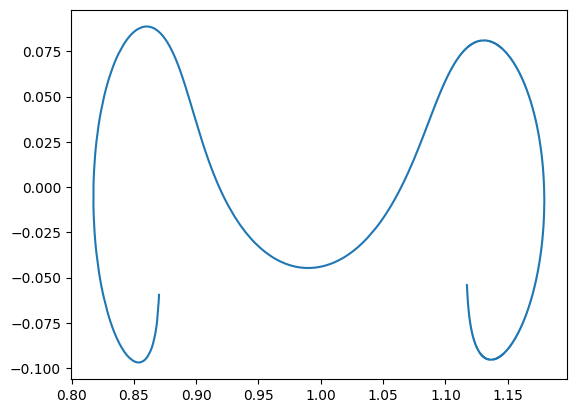

In [54]:
plt.plot(trajectory[:,0], trajectory[:,1])

In [55]:
# three body problem env
class ThreeBodyEnv(gym.Env):
    def __init__(self, trajectory_, error_range=0.1, final_range=0.1):
        self.trajectory = trajectory_
        self.state = np.zeros(4)
        self.dt = 0.01
        self.mu = 0.012277471
        self.action_space = spaces.Box(low=-10, high=10, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.position = trajectory_[0]
        self.steps = 0
        self.max_steps = 1000
        self.final_range = final_range
        self.error_range = error_range
        self.reward_range = (-float('inf'), float('inf'))
        self.render_logic = False
        # second player
        self.second_player = False
        self.reset()

    def step(self, action):
        x = self.position[0]
        y = self.position[1]
        xdot = self.position[2]
        ydot = self.position[3]

        # force = action[0] * env.state[2:] + action[1] * env.state[:2]
        a_x = action[0]/10
        a_y = action[1]/10
        # add second player action
        a_x_2 = action[2]/10 if self.second_player else 0
        a_y_2 = action[3]/10 if self.second_player else 0


        r1 = np.sqrt((x+self.mu)**2 + y**2)
        r2 = np.sqrt((x-1+self.mu)**2 + y**2)

        xddot = 2*ydot + x -(1-self.mu)*((x+self.mu)/(r1**3)) - self.mu*(x-1+self.mu)/(r2**3) + a_x + a_x_2
        yddot = -2*xdot + y - (1-self.mu)*(y/(r1**3)) - self.mu*y/(r2**3) + a_y + a_y_2

        x = x + xdot*self.dt
        y = y + ydot*self.dt

        xdot = xdot + xddot*self.dt
        ydot = ydot + yddot*self.dt

        self.position = np.array([x, y, xdot, ydot])

        self.steps += 1

        self.position2state()

        # plot position
        if self.render_logic:
            plt.plot(x, y, 'ro')
            plt.plot(self.trajectory[:,0], self.trajectory[:,1])
            plt.show()

        reward = 1 - np.linalg.norm(self.state, axis=0) + self.steps /1000 - (a_x/10)**2 - (a_y/10)**2 + (a_x_2/10)**2 + (a_y_2/10)**2
        done = self.steps >= self.max_steps
        if np.linalg.norm(self.position[0:2] - self.trajectory[-1, 0:2]) < self.final_range:
            done = True
            reward = 10
            print(colorize("done 🥺", 'green', bold=True))
        if self.steps > 1000:
            done = True
            reward = -10
            print("end time")
        if self.error_calculation() > self.error_range:
            done = True
            reward = -10
            print(colorize("too much error 🥲😱", 'red', bold=True))


        # print(self.state, reward, done, self.position)
        return 1000*self.state, reward, done, False, self.position

    def position2state(self):
        # find the nearest point from position to trajectory
        distance = np.linalg.norm(self.trajectory - self.position, axis=1)
        nearest_idx = np.argmin(distance)
        # estate = position - nearest(index)
        self.state = self.position - self.trajectory[nearest_idx]

    def error_calculation(self):
        normalized_error = np.copy(self.state[0:2]) * np.array([1, 10])
        return np.linalg.norm(normalized_error)

    def reset(self,
              *,
              seed: 5 = None,
              return_info: bool = False,
              options: 6 = None):
        self.position = self.trajectory[0]
        self.steps = 0
        self.position2state()
        return 10000*self.state, {}

## Soft Actor-Critic (SAC) Algorithm

In [56]:
class ReplayBuffer:
    """
    A simple FIFO experience replay buffer for SAC agents.
    """

    def __init__(self, obs_dim, act_dim, size, device_class=torch.device("cpu")):
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size
        self.device = device_class

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32, device=self.device) for k,v in batch.items()}



class SAC:
    def __init__ (self, env_fn, actor_critic=MLPActorCritic, ac_kwargs_class=None, seed=0,
                  steps_per_epoch=4000, epochs=100, replay_size=int(1e6), gamma=0.99,
                  polyak=0.995, lr=1e-3, alpha=0.2, batch_size=128, start_steps=10000,
                  update_after=1000, num_updates=10, update_every=50, num_test_episodes=10, max_ep_len=1000,
                  logger_kwargs=None, save_freq=1, device_class=torch.device("cpu")):
        
        self.env_fn = env_fn
        self.actor_critic = actor_critic
        self.ac_kwargs = ac_kwargs_class
        self.seed = seed
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.replay_size = replay_size
        self.gamma = gamma
        self.polyak = polyak
        self.lr = lr
        self.alpha = alpha
        self.batch_size = batch_size
        self.start_steps = start_steps
        self.update_after = update_after
        self.update_every = update_every
        self.num_updates = num_updates
        self.num_test_episodes = num_test_episodes
        self.max_ep_len = max_ep_len
        self.logger_kwargs = logger_kwargs
        self.save_freq = save_freq
        self.device = device_class
        """
        Soft Actor-Critic (SAC)


        Args:
            env_fn : A function which creates a copy of the environment.
                The environment must satisfy the OpenAI Gym API.

            actor_critic: The constructor method for a PyTorch Module with an ``act`` 
                method, a ``pi`` module, a ``q1`` module, and a ``q2`` module.
                The ``act`` method and ``pi`` module should accept batches of 
                observations as inputs, and ``q1`` and ``q2`` should accept a batch 
                of observations and a batch of actions as inputs. When called, 
                ``act``, ``q1``, and ``q2`` should return:

                ===========  ================  ======================================
                Call         Output Shape      Description
                ===========  ================  ======================================
                ``act``      (batch, act_dim)  | Numpy array of actions for each 
                                               | observation.
                ``q1``       (batch,)          | Tensor containing one current estimate
                                               | of Q* for the provided observations
                                               | and actions. (Critical: make sure to
                                               | flatten this!)
                ``q2``       (batch,)          | Tensor containing the other current 
                                               | estimate of Q* for the provided observations
                                               | and actions. (Critical: make sure to
                                               | flatten this!)
                ===========  ================  ======================================

                Calling ``pi`` should return:

                ===========  ================  ======================================
                Symbol       Shape             Description
                ===========  ================  ======================================
                ``a``        (batch, act_dim)  | Tensor containing actions from policy
                                               | given observations.
                ``logp_pi``  (batch,)          | Tensor containing log probabilities of
                                               | actions in ``a``. Importantly: gradients
                                               | should be able to flow back into ``a``.
                ===========  ================  ======================================

            ac_kwargs (dict): Any kwargs appropriate for the ActorCritic object 
                you provided to SAC.

            seed (int): Seed for random number generators.

            steps_per_epoch (int): Number of steps of interaction (state-action pairs) 
                for the agent and the environment in each epoch.

            epochs (int): Number of epochs to run and train agent.

            replay_size (int): Maximum length of replay buffer.

            gamma (float): Discount factor. (Always between 0 and 1.)

            polyak (float): Interpolation factor in polyak averaging for target 
                networks. Target networks are updated towards main networks 
                according to:

                .. math:: \\theta_{\\text{targ}} \\left arrow 
                    \\rho \\theta_{\\text{targ}} + (1-\\rho) \\theta

                where: math:`\\rho` is polyak. (Always between 0 and 1, usually 
                close to 1.)

            lr (float): Learning rate (used for both policy and value learning).

            alpha (float): Entropy regularization coefficient. (Equivalent to 
                inverse of a reward scale in the original SAC paper.)

            batch_size (int): Minibatch size for SGD.

            start_steps (int): Number of steps for uniform-random action selection,
                before running real policy. Help exploration.

            update_after (int): Number of env interactions to collect before
                starting to do gradient descent updates. Ensures replay buffer
                is full enough for useful updates.

            update_every (int): Number of env interactions that should elapse
                between gradient descent updates. Note: Regardless of how long 
                you wait between updates, the ratio of env steps to gradient steps 
                is locked to 1.

            num_test_episodes (int): Number of episodes to test the deterministic
                policy at the end of each epoch.

            max_ep_len (int): Maximum length of trajectory / episode / rollout.

            logger_kwargs (dict): Keyword args for EpochLogger.

            save_freq (int): How often (in terms of gap between epochs) to save
                the current policy and value function.

        """

        if self.ac_kwargs is None:
            self.ac_kwargs = dict()
        if self.logger_kwargs is None:
            self.logger_kwargs = dict()
        self.logger = EpochLogger(**self.logger_kwargs)
        self.logger.save_config(locals())

        torch.manual_seed(seed)
        np.random.seed(seed)

        self.env, self.test_env = self.env_fn(), self.env_fn()
        self.obs_dim = self.env.observation_space.shape
        self.act_dim = self.env.action_space.shape[0]

        # Action limit for clamping: critically, assumes all dimensions share the same bound!
        self.act_limit = self.env.action_space.high[0]

        # Create actor-critic module and target networks
        self.ac = actor_critic(self.env.observation_space, self.env.action_space, **self.ac_kwargs)
        self.ac_targ = deepcopy(self.ac)

        # Freeze target networks with respect to optimizers (only update via polyak averaging)
        for p in self.ac_targ.parameters():
            p.requires_grad = False
            
        # List of parameters for both Q-networks (save this for convenience)
        self.q_params = itertools.chain(self.ac.q1.parameters(), self.ac.q2.parameters())

        # Experience buffer
        self.replay_buffer = ReplayBuffer(obs_dim=self.obs_dim, act_dim=self.act_dim, size=self.replay_size, device_class=self.device)

        # Count variables (protip: try to get a feel for how different size networks behave!)
        self.var_counts = tuple(count_vars(module) for module in [self.ac.pi, self.ac.q1, self.ac.q2])
        self.logger.log('\nNumber of parameters: \t pi: %d, \t q1: %d, \t q2: %d\n'%self.var_counts)
        
        # set up optimizers for policy and q-function
        self.pi_optimizer = Adam(self.ac.pi.parameters(), lr=lr)
        self.q_optimizer = Adam(self.q_params, lr=lr)

        # set up model saving
        self.logger.setup_pytorch_saver(self.ac)

    # Set up function for computing SAC Q-losses
    def compute_loss_q(self, data):
        o, a, r, o2, d = data['obs'], data['act'], data['rew'], data['obs2'], data['done']

        q1 = self.ac.q1(o,a)
        q2 = self.ac.q2(o,a)

        # Bellman backup for Q functions
        with torch.no_grad():
            # Target actions come from *current* policy
            a2, logp_a2 = self.ac.pi(o2)

            # Target Q-values
            q1_pi_targ = self.ac_targ.q1(o2, a2)
            q2_pi_targ = self.ac_targ.q2(o2, a2)
            q_pi_targ = torch.min(q1_pi_targ, q2_pi_targ)
            backup = r + self.gamma * (1 - d) * (q_pi_targ - self.alpha * logp_a2)

        # MSE loss against Bellman backup
        loss_q1 = ((q1 - backup)**2).mean()
        loss_q2 = ((q2 - backup)**2).mean()
        loss_q = loss_q1 + loss_q2

        # Useful info for logging
        q_info = dict(Q1Vals=q1.detach().cpu().numpy(),
                      Q2Vals=q2.detach().cpu().numpy())

        return loss_q, q_info

    # Set up function for computing SAC pi loss
    def compute_loss_pi(self ,data):
        o = data['obs']
        pi, logp_pi = self.ac.pi(o)
        q1_pi = self.ac.q1(o, pi)
        q2_pi = self.ac.q2(o, pi)
        q_pi = torch.min(q1_pi, q2_pi)

        # Entropy-regularized policy loss
        loss_pi = (self.alpha * logp_pi - q_pi).mean()

        # Useful info for logging
        pi_info = dict(LogPi=logp_pi.detach().cpu().numpy())

        return loss_pi, pi_info

    

    def update(self, data):
        # First run one gradient descent step for Q1 and Q2
        self.q_optimizer.zero_grad()
        loss_q, q_info = self.compute_loss_q(data)
        loss_q.backward()
        self.q_optimizer.step()

        # Record things
        self.logger.store(LossQ=loss_q.item(), **q_info)

        # Freeze Q-networks so you don't waste computational effort 
        # computing gradients for them during the policy learning step.
        for p in self.q_params:
            p.requires_grad = False

        # Next run one gradient descent step for pi.
        self.pi_optimizer.zero_grad()
        loss_pi, pi_info = self.compute_loss_pi(data)
        loss_pi.backward()
        self.pi_optimizer.step()

        # Unfreeze Q-networks so you can optimize it at next DDPG step.
        for p in self.q_params:
            p.requires_grad = True

        # Record things
        self.logger.store(LossPi=loss_pi.item(), **pi_info)

        # Finally, update target networks by polyak averaging.
        with torch.no_grad():
            for p, p_targ in zip(self.ac.parameters(), self.ac_targ.parameters()):
                # NB: We use the in-place operations "mul_", "add_" to update target
                # params, as opposed to "mul" and "add", which would make new tensors.
                p_targ.data.mul_(self.polyak)
                p_targ.data.add_((1 - self.polyak) * p.data)

    def get_action(self, o, deterministic=False):
        return self.ac.act(torch.as_tensor(o, dtype=torch.float32, device=self.device), 
                      deterministic)


    def train(self, epochs=1000):
        # Prepare for interaction with environment
        total_steps = self.steps_per_epoch * epochs
        start_time = time.time()
        o, _ = self.env.reset()
        ep_ret, ep_len = 0, 0
        # Main loop: collect experience in env and update/log each epoch
        for t in range(total_steps):
             # Until start_steps have elapsed, randomly sample actions
            # from a uniform distribution for better exploration. Afterward, 
            # use the learned policy. 
            if t > self.start_steps:
                a = self.get_action(o)
            else:
                a = self.env.action_space.sample()

            # Step the env
            o2, r, d, _, _ = self.env.step(a)
            ep_ret += r
            ep_len += 1

            # Ignore the "done" signal if it comes from hitting the time
            # horizon (that is, when it's an artificial terminal signal
            # that isn't based on the agent's state)
            d = False if ep_len==self.max_ep_len else d

            # Store experience to replay buffer
            self.replay_buffer.store(o, a, r, o2, d)

            # Supercritical, easy to overlook a step: make sure to update 
            # the most recent observation!
            o = o2

            # End of trajectory handling
            if d or (ep_len == self.max_ep_len):
                self.logger.store(EpRet=ep_ret, EpLen=ep_len)
                o, _ = self.env.reset()
                ep_ret, ep_len = 0, 0

            # Update handling
            if t >= self.update_after and t % self.update_every == 0:
                print(colorize("updating 🥰", 'blue', bold=True))
                for j in range(self.num_updates):
                    batch = self.replay_buffer.sample_batch(self.batch_size)
                    self.update(data=batch)

            # End of epoch handling
            if (t+1) % self.steps_per_epoch == 0:
                epoch = (t+1) // self.steps_per_epoch

                # Save model
                if (epoch % self.save_freq == 0) or (epoch == epochs):
                    self.logger.save_state({'env': self.env}, None)


                # Log info about epoch
                self.logger.log_tabular('Epoch', epoch)
                self.logger.log_tabular('EpRet', with_min_and_max=True)
                # self.logger.log_tabular('TestEpRet', with_min_and_max=True)
                self.logger.log_tabular('EpLen', average_only=True)
                # self.logger.log_tabular('TestEpLen', average_only=True)
                self.logger.log_tabular('TotalEnvInteracts', t)
                self.logger.log_tabular('Q1Vals', with_min_and_max=True)
                self.logger.log_tabular('Q2Vals', with_min_and_max=True)
                self.logger.log_tabular('LogPi', with_min_and_max=True)
                self.logger.log_tabular('LossPi', average_only=True)
                self.logger.log_tabular('LossQ', average_only=True)
                self.logger.log_tabular('Time', time.time()-start_time)
                self.logger.dump_tabular()


    def test(self, fun_mode=False, deterministic=True, save_data=True):
        o, _ = self.env.reset()
        state_array = []
        action_array = []
        while True:
            a = self.ac.act(torch.as_tensor(o, dtype=torch.float32, device=self.device), deterministic=deterministic)
            action_array.append(a)
            o, _, d, _, position = self.env.step(a)
            state_array.append(position)
            if d:
                break
        dt = self.env.dt
        time = np.arange(0, len(state_array)*dt, dt)
        state_array = np.array(state_array)
        action_array = np.array(action_array)
        # save trajectory and actions to csv
        if not os.path.exists('results/') and save_data:
            os.makedirs('results/')

        # numpy to pandas with header
        state_df = pd.DataFrame(state_array, columns=['x', 'y', 'xdot', 'ydot'])
        action_df = pd.DataFrame(action_array, columns=['ax', 'ay'])

        # save to csv
        if save_data:
            state_df.to_csv('results/state.csv', index=False)
            action_df.to_csv('results/action.csv', index=False)
            print(colorize("Data saved to results folder 😜", 'green', bold=True))


        if fun_mode:
            # Use XKCD style for hand-drawn look
            with plt.xkcd():
                plt.plot(state_array[:,0], state_array[:,1], label='State')
                plt.plot(trajectory[:,0], trajectory[:,1], label='Trajectory')
                plt.legend()
                plt.show()
            with plt.xkcd():
                plt.plot(time, action_array)
                plt.xlabel("Time (sec)")
                plt.ylabel("action (N)")
                plt.show()
        else:
            plt.plot(state_array[:,0], state_array[:,1], label='State')
            plt.plot(trajectory[:,0], trajectory[:,1], label='Trajectory')
            plt.legend()
            plt.show()

            plt.plot(action_array)
            plt.xlabel("Time (sec)")
            plt.ylabel("action (N)")
            plt.show()

    # save actor critic
    def save(self, filepath='model/'):
        if not os.path.isdir(filepath):
            os.mkdir(filepath)
        # Check the device of the model
        if self.ac.pi.device.type == 'cuda':
            torch.save(self.ac.pi.state_dict(), filepath + 'actor_cuda.pth')
            torch.save(self.ac.q1.state_dict(), filepath + 'q1_cuda.pth')
            torch.save(self.ac.q2.state_dict(), filepath + 'q2_cuda.pth')
        else:
            torch.save(self.ac.pi.state_dict(), filepath + 'actor_cpu.pth')
            torch.save(self.ac.q1.state_dict(), filepath + 'q1_cpu.pth')
            torch.save(self.ac.q2.state_dict(), filepath + 'q2_cpu.pth')
        print(colorize(f"Model saved successfully! 🥰😎", 'blue', bold=True))

        
    # load actor critic
    def load(self, filepath='model/', load_device=torch.device("cpu"),from_device_to_load='cpu'):
        # check if the model is available
        if os.path.isfile(filepath + 'actor_cpu.pth') or os.path.isfile(filepath + 'actor_cuda.pth'):
             # Check the device of the model
            if from_device_to_load == 'cpu':
                actor_file = 'actor_cpu.pth'
                q1_file = 'q1_cpu.pth'
                q2_file = 'q2_cpu.pth'
            else:
                actor_file = 'actor_cuda.pth'
                q1_file = 'q1_cuda.pth'
                q2_file = 'q2_cuda.pth'

            if from_device_to_load == 'cpu' and load_device.type == 'cuda':
                self.ac.pi.load_state_dict(torch.load(filepath + actor_file, map_location=torch.device('cuda')))
                self.ac.q1.load_state_dict(torch.load(filepath + q1_file, map_location=torch.device('cuda')))
                self.ac.q2.load_state_dict(torch.load(filepath + q2_file, map_location=torch.device('cuda')))
            elif from_device_to_load == 'cuda' and load_device.type == 'cpu':
                self.ac.pi.load_state_dict(torch.load(filepath + actor_file, map_location=torch.device('cpu')))
                self.ac.q1.load_state_dict(torch.load(filepath + q1_file, map_location=torch.device('cpu')))
                self.ac.q2.load_state_dict(torch.load(filepath + q2_file, map_location=torch.device('cpu')))
            else: # TODO: fix for cuda
                self.ac.pi.load_state_dict(torch.load(filepath + actor_file, map_location=load_device))
                self.ac.q1.load_state_dict(torch.load(filepath + q1_file, map_location=load_device))
                self.ac.q2.load_state_dict(torch.load(filepath + q2_file, map_location=load_device))
            print(colorize(f"Model loaded successfully and device is {load_device}! 🥰😎", 'blue', bold=True))
        else:
            print(colorize("Model not found! 😱🥲", 'red', bold=True))

        
                
                

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(colorize(f"Device is {device}! 🥰😎", 'green', bold=True))
ac_kwargs = dict(hidden_sizes=[64, 64], activation=nn.PReLU, device_class=device)
sac_rl = SAC(lambda : ThreeBodyEnv(trajectory, error_range=0.05, final_range=0.02), epochs=100, device_class=device, ac_kwargs_class=ac_kwargs)

Device is cpu! 🥰😎
Logging data to /tmp/experiments/1736080787/progress.txt
Saving config:

{
    "ac_kwargs_class":	{
        "activation":	"PReLU",
        "device_class":	"cpu",
        "hidden_sizes":	[
            64,
            64
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "alpha":	0.2,
    "batch_size":	128,
    "device_class":	"cpu",
    "env_fn":	"<function <lambda> at 0x12932d9e0>",
    "epochs":	100,
    "gamma":	0.99,
    "logger_kwargs":	null,
    "lr":	0.001,
    "max_ep_len":	1000,
    "num_test_episodes":	10,
    "num_updates":	10,
    "polyak":	0.995,
    "replay_size":	1000000,
    "save_freq":	1,
    "seed":	0,
    "self":	{
        "<__main__.SAC object at 0x12a5b08d0>":	{
            "ac_kwargs":	{
                "activation":	"PReLU",
                "device_class":	"cpu",
                "hidden_sizes":	[
                    64,
                    64
                ]
            },
            "actor_critic":	"MLPActorCritic",
            "alph

SquashedGaussianMLPActor(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Identity()
  )
  (mu_layer): Linear(in_features=64, out_features=2, bias=True)
  (log_std_layer): Linear(in_features=64, out_features=2, bias=True)
)


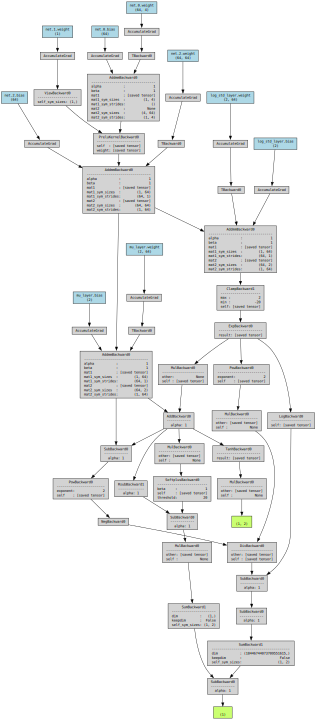

In [28]:
print(sac_rl.ac.pi)
dot = torchviz.make_dot(sac_rl.ac.pi(torch.randn(1, sac_rl.obs_dim[0], device=device)), params=dict(sac_rl.ac.pi.named_parameters()), show_attrs=True)
dot.graph_attr.update(size="10,10")
dot

too much error 🥲😱
Data saved to results folder 😜


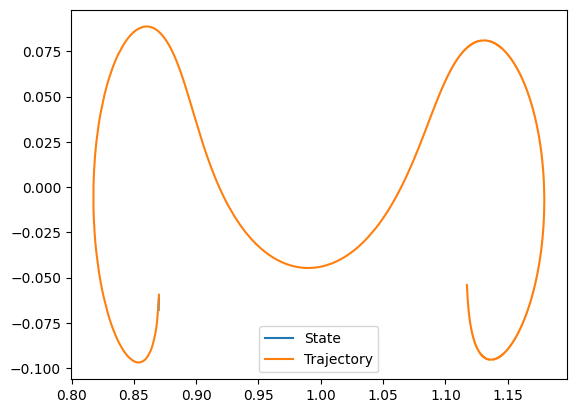

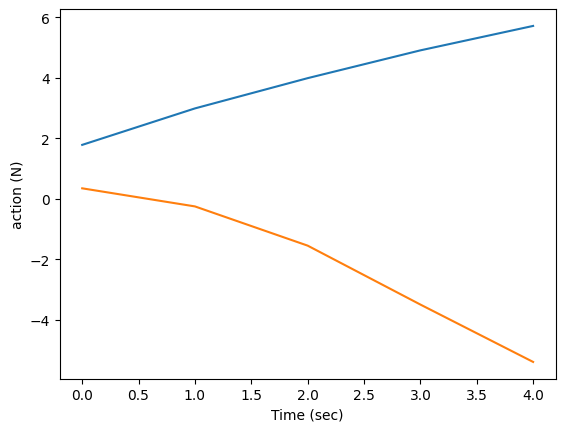

In [29]:
sac_rl.test(deterministic=True)

Model loaded successfully and device is cpu! 🥰😎
too much error 🥲😱
Data saved to results folder 😜


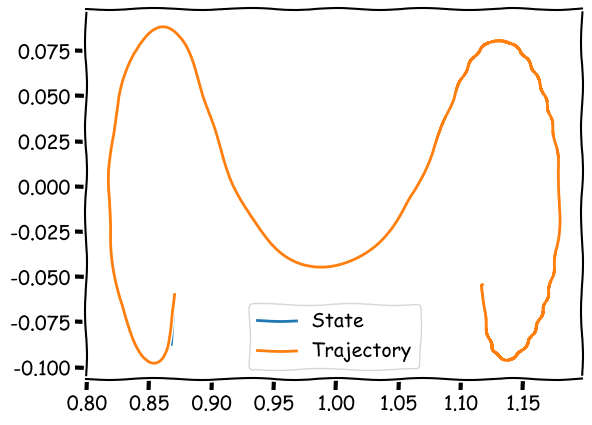

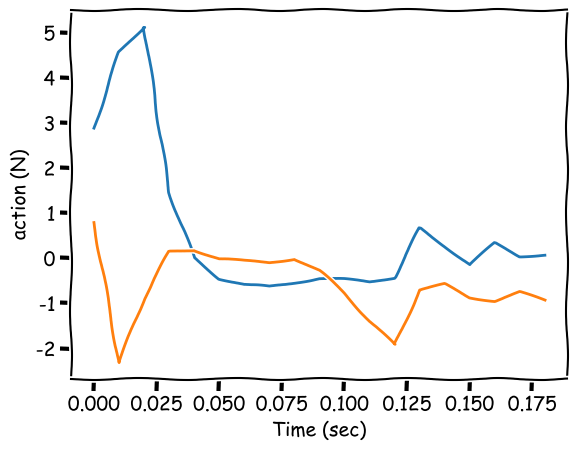

In [30]:
train = False
if train:
    sac_rl.train()
    sac_rl.save()
else:
    sac_rl.load(load_device=torch.device("cpu"), from_device_to_load='cuda')
    sac_rl.test(deterministic=True, fun_mode=True)

In [31]:
if train:
    try:
        # noinspection PyUnresolvedReferences
        import google.colab
        # download created models
        if os.path.isfile("sac_TBP_results.tar.gz"):
            os.remove("sac_TBP_results.tar.gz")
        !tar cvfz sac_TBP_results.tar.gz model/
        # noinspection PyUnresolvedReferences
        from google.colab import files
        files.download('sac_TBP_results.tar.gz')
        print(colorize("Done! 🥰😎", 'blue', bold=True))
    except Exception as e:
        print(e, end=' ----> ')
        print(colorize("Something Wrong 🧐😩, or maybe you used your Mac 😱🥲", 'red', bold=True))
else:
    print(colorize("You are in test mode! 🥰😎", 'blue', bold=True))

You are in test mode! 🥰😎


In [58]:
# copy model
pi_model = deepcopy(sac_rl.ac.pi)
print(
    f"Model copied successfully! 🥰😎",
    pi_model
)


Model copied successfully! 🥰😎 SquashedGaussianMLPActor(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Identity()
  )
  (mu_layer): Linear(in_features=64, out_features=2, bias=True)
  (log_std_layer): Linear(in_features=64, out_features=2, bias=True)
)


In [59]:
pi_model.eval()

SquashedGaussianMLPActor(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Identity()
  )
  (mu_layer): Linear(in_features=64, out_features=2, bias=True)
  (log_std_layer): Linear(in_features=64, out_features=2, bias=True)
)

In [60]:
dummy_input = torch.randn(1, sac_rl.obs_dim[0], device=device)
print(pi_model(dummy_input))

(tensor([[ 2.2903, -0.4324]], grad_fn=<MulBackward0>), tensor([-1.8182], grad_fn=<SubBackward0>))


In [61]:
pi_model.eval()
# Trace the model
traced_model = torch.jit.trace(pi_model, dummy_input)

# Save the traced model
traced_model.save("pi_model_traced.pt")

In [63]:
with torch.no_grad():
    original_output, original_logp = pi_model(dummy_input, deterministic=True, with_logprob=True)
    traced_output, traced_logp = traced_model(dummy_input)

    # Check if the outputs are identical
    output_close = torch.allclose(original_output, traced_output, atol=1e-6)
    logp_close = torch.allclose(original_logp, traced_logp, atol=1e-6) if original_logp is not None else True

    if output_close and logp_close:
        print("The traced model is deterministic and matches the original model.")
    else:
        print("There is a discrepancy between the original and traced models.")
        if not output_close:
            print("Outputs do not match.")
        if not logp_close:
            print("Log probabilities do not match.")


The traced model is deterministic and matches the original model.
